In [1]:
import ACTIONet as an
import scanpy as sc
import anndata as AN
import pandas as pd
import numpy as np

In [3]:
# load data
meta = np.load('./processed_data/single_cell/filtered_meta.npy', allow_pickle=True)
meta_names = np.load('./processed_data/single_cell/meta_names.npy', allow_pickle=True)
features = np.load('./processed_data/single_cell/features.npy')
counts = np.memmap('./processed_data/single_cell/filtered_counts.npy', mode='r+', shape=(meta.shape[0], features.shape[0]), dtype='int16')
marker_indices = np.load('./processed_data/single_cell/marker_indices.npy')

In [101]:
# subset
index = meta[:,np.where(meta_names=='keep_cells_all_per_celltype')[0][0]].astype(bool)
index2 = meta[:,np.where(meta_names=='keep_cells_gaussian')[0][0]].astype(bool)
index_all = index#&index2

META = meta[index_all]
COUNTS = counts[index_all][:,marker_indices]

META_df = pd.DataFrame(META)
META_df.columns = meta_names
META_df.index = META_df['barcodes']

FEATURES_df = pd.DataFrame(features[marker_indices])
FEATURES_df.columns = ['Gene', 'ID']
FEATURES_df.index = FEATURES_df['Gene']

COUNTS_df = pd.DataFrame(COUNTS)
COUNTS_df.columns = FEATURES_df['Gene']
COUNTS_df.index = META_df['barcodes']


In [102]:
# make adata
adata = an.AnnData(X=COUNTS_df, obsm=META_df, varm=FEATURES_df)
adata.uns['metadata'] = META_df
adata.var_names_make_unique(join='.')
adata.obs_names_make_unique(join='.')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



In [103]:
# reduce and batch correct
an.pp.reduce_and_batch_correct_adata_Harmony(data=adata, batch_key=np.array(adata.obsm['seq_batch']))

Computing reduced ACTION kernel (dense):
	Performing SVD on original matrix: IRLB (dense) -- A: 720 x 118120


In [104]:
an.run_ACTIONet(adata, reduction_key='Harmony')

Harmony 0/10
Harmony 1/10
Harmony converged after 1 iterations
Running ACTION (94 threads):
	Iterating from k = 2 ... 30: 29/29 finished 2 ... 30: 22/29 finished
Joining trace of C & H matrices (depth = 30) ... done (464 archetypes)
Pruning archetypes:
	Non-specific archetypes: 12
	Unreliable archetypes: 82
	Trivial archetypes: 3
Unifying 370 archetypes (94 threads):
# unified archetypes: 22
Building adaptive network (density = 1.00)
	Building index ... done
	Identifying nearest neighbors ... done
	Constructing adaptive-nearest neighbor graph ... done
	Finalizing network ... 
		Keeping mutual nearest-neighbors only ... done
Laying-out input network: method = umap, a = 0.115, b = 1.929 (epochs = 100, threads=94)
Computing 2D layout ... done
Computing 3D layout ... done
Computing de novo node colors ... done
Computing feature specificity ... done
Building adaptive network (density = 0.50)
	Building index ... done
	Identifying nearest neighbors ... done
	Constructing adaptive-nearest neig

In [ ]:
an.rerun_layout(adata, layout_spread=.8)#, thread_no=40)

In [1]:
A = np.array((adata.obs['node_centrality']/np.max(adata.obs['node_centrality'])).astype(float))

NameError: name 'np' is not defined

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/relational.py:654: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<AxesSubplot:>

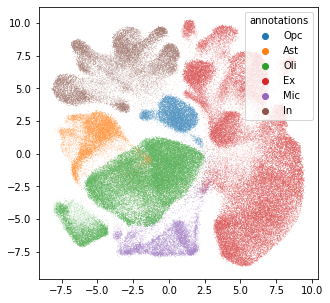

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))

d = adata.obsm['ACTIONet2D']
sns.scatterplot(d[:,0], d[:,1], s=.5, alpha = A, hue = META_df['annotations'])#, hue=annotation[index_row])

In [100]:
np.unique(META_df['annotations'], return_counts=True)

(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc'], dtype=object),
 array([ 6718, 39203,  3648,  6512, 28656,  5353]))

In [ ]:
(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc'], dtype='<U3'),
 array([ 9604, 48717, 16749,  7670, 34745,  6794]))

In [89]:
Ast  Endo    Ex    In   Mic   Oli   Opc 
 6478   630 41635 13948  4420 27067  4519 

Help on function run_ACTIONet in module ACTIONet.main:

run_ACTIONet(adata: anndata._core.anndata.AnnData, k_min: Union[int, NoneType] = 2, k_max: Union[int, NoneType] = 30, layer_key: Union[str, NoneType] = None, reduction_key: Union[str, NoneType] = None, normalization: Union[int, NoneType] = 1, net_key_out: Union[str, NoneType] = 'ACTIONet', min_cells_per_archetype: Union[int, NoneType] = 2, max_iter_ACTION: Union[int, NoneType] = 50, specificity_th: Union[int, NoneType] = -3, network_metric: Union[str, NoneType] = 'jsd', network_algorithm: Union[str, NoneType] = 'k*nn', network_density: Union[int, NoneType] = 1, network_k: Union[int, NoneType] = 30, mutual_edges_only: Union[bool, NoneType] = True, layout_epochs: Union[int, NoneType] = 100, layout_algorithm: Union[str, NoneType] = 'umap', layout_presmooth_network: Union[bool, NoneType] = False, layout_sim2dist: Union[int, NoneType] = 2, layout_min_dist: Union[float, NoneType] = 1.0, layout_spread: Union[float, NoneType] = 1.0, layou

In [73]:
A = np.array(adata.obs['node_centrality']/np.max(adata.obs['node_centrality'])).astype('float')

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/relational.py:654: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<AxesSubplot:>

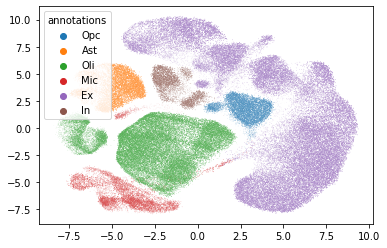

In [74]:
import seaborn as sns
d = adata.obsm['ACTIONet2D']
sns.scatterplot(d[:,0], d[:,1], s=.5, alpha=A, hue = META_df['annotations'])#, hue=annotation[index_row])

In [76]:
an.

AttributeError: module 'ACTIONet.tools' has no attribute 'annotate_cells_using_markers'

In [75]:
cell_labels, confidences, Z = an.tl.annotate_cells_using_markers(adata, marker_genes, directions, names)


AttributeError: module 'ACTIONet.tools' has no attribute 'load_markers'

In [ ]:
# get labels, confidences on labels, and coords, and node centrality measure

In [161]:
import ACTIONet as an


In [162]:
help(an.run_ACTIONet)

Help on function run_ACTIONet in module ACTIONet.main:

run_ACTIONet(adata: anndata._core.anndata.AnnData, k_min: Union[int, NoneType] = 2, k_max: Union[int, NoneType] = 30, layer_key: Union[str, NoneType] = None, reduction_key: Union[str, NoneType] = None, normalization: Union[int, NoneType] = 1, net_key_out: Union[str, NoneType] = 'ACTIONet', min_cells_per_archetype: Union[int, NoneType] = 2, max_iter_ACTION: Union[int, NoneType] = 50, specificity_th: Union[int, NoneType] = -3, network_metric: Union[str, NoneType] = 'jsd', network_algorithm: Union[str, NoneType] = 'k*nn', network_density: Union[int, NoneType] = 1, network_k: Union[int, NoneType] = 30, mutual_edges_only: Union[bool, NoneType] = True, layout_epochs: Union[int, NoneType] = 100, layout_algorithm: Union[str, NoneType] = 'umap', layout_presmooth_network: Union[bool, NoneType] = False, layout_sim2dist: Union[int, NoneType] = 2, layout_min_dist: Union[float, NoneType] = 1.0, layout_spread: Union[float, NoneType] = 1.0, layou

In [143]:
import numpy as np
import matplotlib.pyplot as plt
d = np.load('./processed_data/single_cell/coords.npy')

<AxesSubplot:>

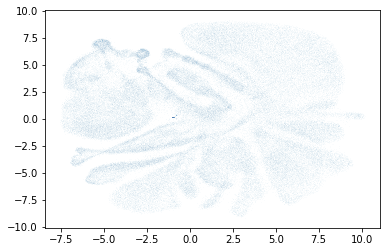

In [151]:
sns.scatterplot(d[:,0], d[:,1], s=.5, alpha=.05)#, hue=annotation[index_row])

In [145]:
d.shape

(114274, 2)

In [152]:
meta = np.load('./processed_data/single_cell/filtered_meta.npy', allow_pickle=True)
meta_names = np.load('./processed_data/single_cell/meta_names.npy', allow_pickle=True)
features = np.load('./processed_data/single_cell/features.npy')
projected_matrix = np.load('./processed_data/single_cell/projected_matrix.npy')

In [157]:
index_col = np.where(meta_names=='keep_cells_all_per_celltype')[0][0]
index_col2 = np.where(meta_names=='keep_cells_gaussian')[0][0]

index_row = meta[:,index_col].astype(bool)
index_row2 = meta[:,index_col2].astype(bool)

index_all = index_row & index_row2

In [107]:
L = meta[:,np.where(meta_names=='gaussian_liklihood')[0][0]]
L = L.astype(float)

In [36]:
annotation = meta[:,-3]

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

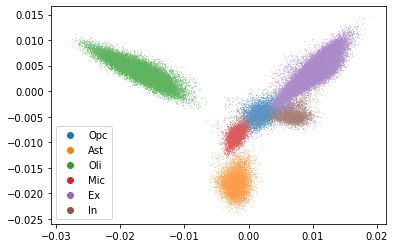

In [160]:
import seaborn as sns
A = np.arange(0,1,1/len(L))[np.argsort(L)]
sns.scatterplot(projected_matrix[index_all,0], projected_matrix[index_all,1], hue=annotation[index_all], s=0.5)#, alpha=L[index_all], s=0.5)

In [142]:
np.sum(L[index_row]>99)

90097

array([ True,  True,  True, ...,  True,  True,  True])

In [117]:
len(L)

124282

In [106]:
L

array([-1059.44480291,  -792.36254146,  -295.04071473, ...,
         110.2767212 ,   110.27910669,   110.29863613])

array([0.0033955 , 0.25594213, 0.56217312, ..., 0.12871534, 0.52544214,
       0.10044093])

In [82]:
x = L+(-1*np.min(L))
x=x/np.max(x)

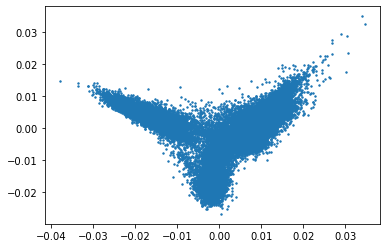

In [30]:
plt.scatter(projected_matrix[index_row,0], projected_matrix[index_row,1], s=2)